### Installing Einit :: עינית ::

In [1]:
!pip install "einit[test] @ git+https://github.com/sashakolpakov/einit.git@main"

  Cloning https://github.com/sashakolpakov/einit.git (to revision main) to /tmp/pip-install-xgm_t8np/einit_52256d1eb8c74aefabd8ef116329ef0c
  Running command git clone --filter=blob:none --quiet https://github.com/sashakolpakov/einit.git /tmp/pip-install-xgm_t8np/einit_52256d1eb8c74aefabd8ef116329ef0c
  Resolved https://github.com/sashakolpakov/einit.git to commit 149b23ce10e75eb2714cf87c7f2f6058d5d826c0
  Preparing metadata (setup.py) ... done
  Created wheel for einit: filename=einit-0.2.0-py3-none-any.whl size=18851 sha256=f5ae474632b783100db2e4472957e3cec428dfbdd7b902b265ed4b17eaee6c67
  Stored in directory: /tmp/pip-ephem-wheel-cache-8k550bu0/wheels/33/0a/19/2bf96995cdafccffdbaefd3ab1a795cf1b234b035e2ada1bcc
Successfully built einit


In [34]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.1
    Uninst

### Imports and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import timeit
from einit import register_ellipsoid

In [2]:
# Style for the visuals
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')

# Random seed for reproducibility
np.random.seed(42)

### Helper functions

In [3]:
def apply_transform(pts, T):
    """Apply a 4x4 homogeneous transform T to an (N,3) array of points."""
    N = pts.shape[0]
    hom = np.hstack([pts, np.ones((N, 1))])
    return (T @ hom.T).T[:, :3]

def random_rigid_transform():
    """Generate a random rigid transformation matrix."""
    A = np.random.normal(size=(3, 3))
    Q, _ = np.linalg.qr(A)
    if np.linalg.det(Q) < 0:
        Q[:, 0] = -Q[:, 0]
    t = np.random.uniform(-5, 5, size=(3,))
    T = np.eye(4)
    T[:3, :3] = Q
    T[:3, 3] = t
    return T

def plot_point_clouds(src, dst, aligned, title="Point Cloud Alignment"):
    """Plot source, destination, and aligned point clouds."""
    fig = plt.figure(figsize=(15, 5))

    # Source points
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(src[:, 0], src[:, 1], src[:, 2], c='red', alpha=0.6, s=20)
    ax1.set_title('Source Points')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Destination points
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(dst[:, 0], dst[:, 1], dst[:, 2], c='blue', alpha=0.6, s=20)
    ax2.set_title('Destination Points')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Overlay: destination (blue) and aligned source (red)
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(dst[:, 0], dst[:, 1], dst[:, 2], c='blue', alpha=0.6, s=20, label='Target')
    ax3.scatter(aligned[:, 0], aligned[:, 1], aligned[:, 2], c='red', alpha=0.6, s=20, label='Aligned Source')
    ax3.set_title('Alignment Result')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Calculate alignment error
    error = np.linalg.norm(aligned - dst, axis=1)
    print(f"Mean alignment error: {np.mean(error):.6f}")
    print(f"Max alignment error: {np.max(error):.6f}")
    print(f"RMSE: {np.sqrt(np.mean(error**2)):.6f}")

### Test 1 - Random Point Cloud Alignment

=== RANDOM POINT CLOUD ALIGNMENT TEST ===

register_ellipsoid: 0.193 ms ± 0.125 ms over 1000 runs

True transformation matrix:
[[-0.5492873  -0.82411617 -0.13826062  0.53868977]
 [ 0.19090371 -0.28483775  0.93937385 -2.07937746]
 [-0.81353502  0.48959166  0.31378459 -1.21813623]
 [ 0.          0.          0.          1.        ]]

Estimated transformation matrix:
[[-0.54953791 -0.82429133 -0.13620532  0.53885416]
 [ 0.19329426 -0.28404559  0.93912482 -2.07921914]
 [-0.81280097  0.48975699  0.3154246  -1.2184492 ]
 [ 0.          0.          0.          1.        ]]


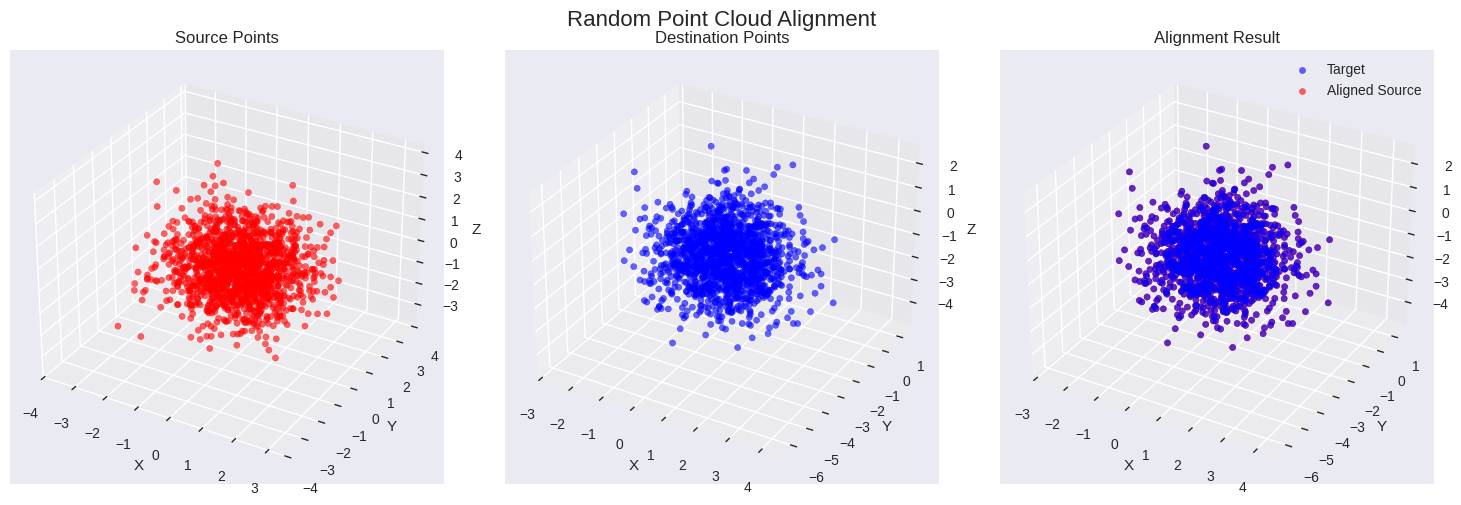

Mean alignment error: 0.003345
Max alignment error: 0.010260
RMSE: 0.003754


In [22]:
print("=== RANDOM POINT CLOUD ALIGNMENT TEST ===")

# Generate random point cloud (e.g., Gaussian blob)
n_points = 1500
src_cloud = np.random.randn(n_points, 3)  # or use np.random.uniform for cube

# Apply random transformation
T_true = random_rigid_transform()
dst_cloud_clean = apply_transform(src_cloud, T_true)

# Apply a random permutation
perm = np.random.permutation(n_points)
dst_cloud = dst_cloud_clean[perm]

# Add small amount of noise
noise = np.random.normal(scale=0.02, size=dst_cloud.shape)
dst_cloud += noise

# Run einit for the timing stats
stmt = "register_ellipsoid(src_cloud, dst_cloud)"
times = timeit.repeat(stmt, globals=globals(), repeat=1000, number=1)

# Convert to ms per call
ms_per_call = np.array(times) / 100 * 1e3
mean_ms = ms_per_call.mean()
std_ms  = ms_per_call.std()
print(f"\nregister_ellipsoid: {mean_ms:.3f} ms ± {std_ms:.3f} ms over 1000 runs")

# Run einit algorithm for the visuals
T_init = register_ellipsoid(src_cloud, dst_cloud)
aligned_cloud = apply_transform(src_cloud, T_init)

print("\nTrue transformation matrix:")
print(T_true)
print("\nEstimated transformation matrix:")
print(T_init)

plot_point_clouds(src_cloud, dst_cloud_clean, aligned_cloud, "Random Point Cloud Alignment")


### Test 2 - Sphere Alignment

=== SPHERE ALIGNMENT TEST ===

register_ellipsoid: 0.144 ms ± 0.032 ms over 1000 runs

True transformation matrix:
[[-0.59620377 -0.78340702  0.1755406  -3.02508162]
 [ 0.01155506 -0.2270022  -0.97382569  3.27505379]
 [ 0.80274999 -0.57857017  0.14439188  1.53332321]
 [ 0.          0.          0.          1.        ]]

Estimated transformation matrix:
[[-0.57657075 -0.80833062  0.11902848 -3.02198549]
 [ 0.08071602 -0.20132034 -0.97619416  3.27408374]
 [ 0.81305049 -0.5532375   0.18132065  1.53067519]
 [ 0.          0.          0.          1.        ]]


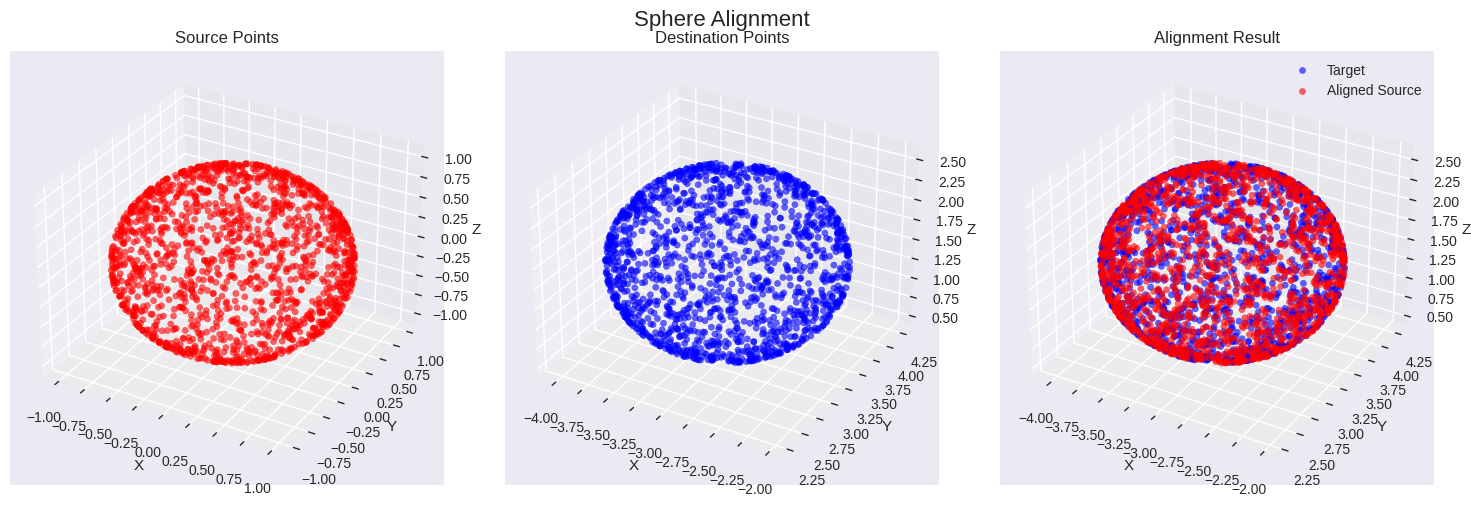

Mean alignment error: 0.059497
Max alignment error: 0.080856
RMSE: 0.062134


In [21]:
print("=== SPHERE ALIGNMENT TEST ===")

# Generate sphere points
n_points = 1500
src_sphere = np.random.randn(n_points, 3)
src_sphere = src_sphere / np.linalg.norm(src_sphere, axis=1, keepdims=True)

# Apply random transformation
T_true = random_rigid_transform()
dst_sphere_clean = apply_transform(src_sphere, T_true)

# Apply a random permutation
perm = np.random.permutation(n_points)
dst_sphere = dst_sphere_clean[perm]

# Add small amount of noise
noise = np.random.normal(scale=0.02, size=dst_sphere.shape)
dst_sphere += noise

# Run einit for the timing stats
stmt = "register_ellipsoid(src_sphere, dst_sphere)"
times = timeit.repeat(stmt, globals=globals(), repeat=1000, number=1)

# Convert to ms per call
ms_per_call = np.array(times) / 100 * 1e3
mean_ms = ms_per_call.mean()
std_ms  = ms_per_call.std()
print(f"\nregister_ellipsoid: {mean_ms:.3f} ms ± {std_ms:.3f} ms over 1000 runs")

# Run einit algorithm for the visuals
T_init = register_ellipsoid(src_sphere, dst_sphere)
aligned_sphere = apply_transform(src_sphere, T_init)

print("\nTrue transformation matrix:")
print(T_true)
print("\nEstimated transformation matrix:")
print(T_init)

plot_point_clouds(src_sphere, dst_sphere_clean, aligned_sphere, "Sphere Alignment")

### Test 3 - Cube with Partial Overlap

=== CUBE ALIGNMENT TEST (Partial Overlap) + ICP ===

register_ellipsoid (cube): 0.134 ms ± 0.032 ms over 1000 runs

True transformation matrix:
[[-0.93349383 -0.04220305  0.35610134 -0.89845555]
 [ 0.30733906 -0.60578281  0.73387321  4.77929574]
 [ 0.18474838  0.79450997  0.57846516 -3.65096883]
 [ 0.          0.          0.          1.        ]]

Estimated transformation matrix:
[[-3.87193450e-01 -7.97714990e-01 -4.62311612e-01 -9.11123701e-01]
 [-9.21990768e-01  3.32944352e-01  1.97689358e-01  4.80002695e+00]
 [-3.77572440e-03  5.02791063e-01 -8.64399729e-01 -3.62798829e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Refined transformation matrix:
[[-0.35746921 -0.9330325   0.04081813 -0.89895289]
 [-0.73424387  0.30778028  0.60510928  4.78029817]
 [-0.57714964  0.18633748 -0.79509537 -3.65112279]
 [ 0.          0.          0.          1.        ]]

It is likely that we fail to recover the initial transformation ...


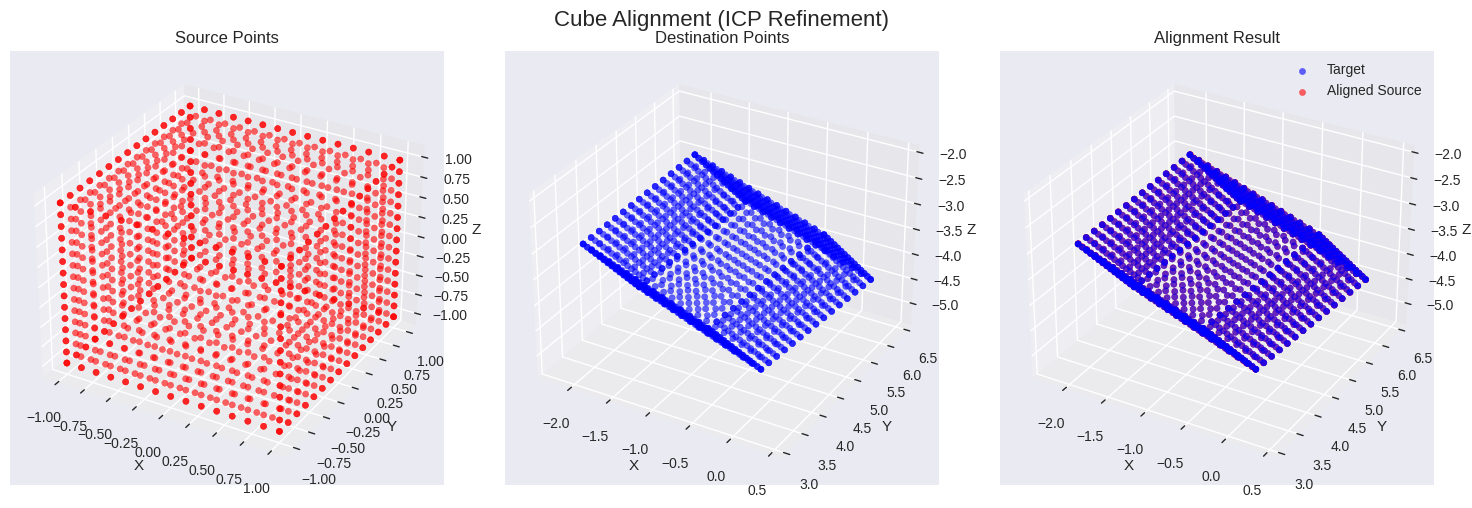

Mean alignment error: 1.758419
Max alignment error: 2.829532
RMSE: 1.876851

The values above are computed on clean clouds ...

The actual ICP residual is 0.03666818531303454


In [60]:
import cv2
from scipy.spatial import cKDTree

print("=== CUBE ALIGNMENT TEST (Partial Overlap) + ICP ===")

# Generate cube surface points
grid = np.linspace(-1, 1, 15)
face = np.array(np.meshgrid(grid, grid)).reshape(2, -1).T

faces = []
for fixed_axis in range(3):
    for fixed_value in [-1, 1]:
        points = np.insert(face, fixed_axis, fixed_value, axis=1)
        faces.append(points)
src_cube_clean = np.vstack(faces)


# Apply transformation
T_true = random_rigid_transform()
dst_cube_clean = apply_transform(src_cube_clean, T_true)

# Simulate partial overlap (80% of points)
src_mask = np.random.choice([True, False], size=(src_cube_clean.shape[0],), p=[0.8, 0.2])
src_cube_partial = src_cube_clean[src_mask]

dst_mask = np.random.choice([True, False], size=(src_cube_clean.shape[0],), p=[0.8, 0.2])
dst_cube_partial = dst_cube_clean[dst_mask]

# Apply random permutation
perm = np.random.permutation(dst_cube_partial.shape[0])
dst_cube_partial = dst_cube_partial[perm]

# Add noise
noise = np.random.normal(scale=0.02, size=dst_cube_partial.shape)
dst_cube_partial += noise

# Run einit algorithm for the timing stats
stmt = "register_ellipsoid(src_cube_partial, dst_cube_partial)"
times = timeit.repeat(stmt, globals=globals(), repeat=1000, number=1)

# Convert to ms per call
ms_per_call = np.array(times) / 100 * 1e3
mean_ms = ms_per_call.mean()
std_ms  = ms_per_call.std()
print(f"\nregister_ellipsoid (cube): {mean_ms:.3f} ms ± {std_ms:.3f} ms over 1000 runs")

# Run einit algorithm for the visuals
T_init = register_ellipsoid(src_cube_partial, dst_cube_partial)
aligned_cube = apply_transform(src_cube_clean, T_init)

def estimate_normals(points, k=3):
    """
    Estimate surface normals for a point cloud using PCA.

    Args:
        points: (N, 3) numpy array
        k: number of neighbors for PCA

    Returns:
        (N, 6) array: [x, y, z, nx, ny, nz]
    """
    tree = cKDTree(points)
    normals = []

    for i in range(len(points)):
        _, idx = tree.query(points[i], k=k + 1)  # include self
        neighbors = points[idx[1:]]  # exclude self
        neighbors_centered = neighbors - neighbors.mean(axis=0)
        _, _, vh = np.linalg.svd(neighbors_centered, full_matrices=False)
        normal = vh[-1]
        normals.append(normal)

    normals = np.array(normals)
    normals /= np.linalg.norm(normals, axis=1, keepdims=True)
    return np.hstack((points.astype(np.float32), normals.astype(np.float32)))


# === ICP refinement step with normals ===

# Apply initial transformation
src_aligned = apply_transform(src_cube_partial, T_init)

# Estimate normals for source and destination
src_icp = estimate_normals(src_aligned, k=5)
dst_icp = estimate_normals(dst_cube_partial, k=5)

# Run OpenCV ICP refinement
icp = cv2.ppf_match_3d_ICP(10)
_, residual, T_icp = icp.registerModelToScene(src_icp, dst_icp)


# Combine transformations
T_refined = T_icp @ T_init
aligned_cube_refined = apply_transform(src_cube_clean, T_refined)

print("\nTrue transformation matrix:")
print(T_true)
print("\nEstimated transformation matrix:")
print(T_init)
print("\nRefined transformation matrix:")
print(T_refined)
print("\nIt is likely that we fail to recover the initial transformation ...")

plot_point_clouds(src_cube_clean, dst_cube_clean, aligned_cube_refined, "Cube Alignment (ICP Refinement)")

print("\nThe values above are computed on clean clouds ...")
print(f"\nThe actual ICP residual is {residual}")

### Test 4 - Stanford Bunny

=== BUNNY ALIGNMENT TEST ===

register_ellipsoid (bunny): 1.006 ms ± 0.252 ms over 1000 runs

Using 795 of 992 points (80.1%)

True transform:
 [[-0.47308687  0.5203063  -0.71096425 -1.19701693]
 [-0.87610355 -0.19273751  0.44192173  1.11921839]
 [ 0.09290518  0.83194567  0.54702379 -1.29748307]
 [ 0.          0.          0.          1.        ]]

Estimated transform:
 [[-0.49041852  0.50080642 -0.71321989 -1.19654456]
 [-0.86630357 -0.19101902  0.46155157  1.12157895]
 [ 0.09490943  0.84421837  0.52752966 -1.3000866 ]
 [ 0.          0.          0.          1.        ]]


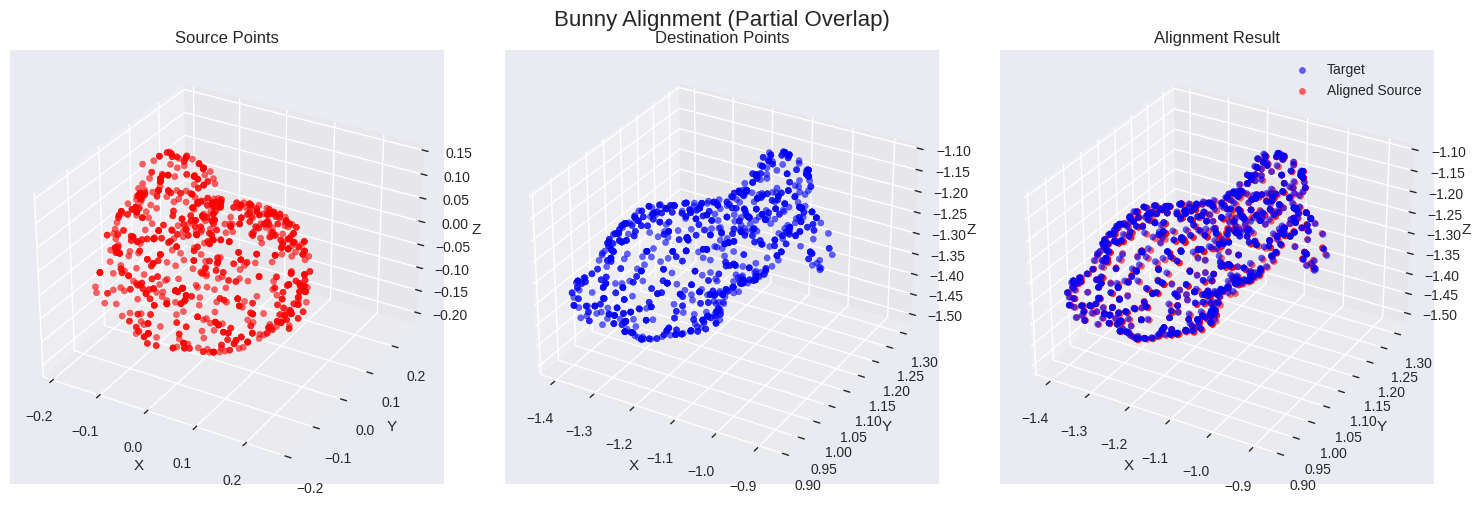

Mean alignment error: 0.004723
Max alignment error: 0.008897
RMSE: 0.005180


In [61]:
import urllib.request

print("=== BUNNY ALIGNMENT TEST ===")

# Download the unoccluded Stanford Bunny point cloud
url = 'https://data.nrel.gov/system/files/153/bunny.csv'
with urllib.request.urlopen(url) as resp:
    bunny = np.loadtxt(resp, delimiter=',')
src_bunny_clean = bunny[:, :3]  # only x,y,z columns

# Apply a random rigid transform and simulate partial overlap + noise
T_true = random_rigid_transform()
dst_bunny_clean = apply_transform(src_bunny_clean, T_true)

# Keep 80% of points for partial overlap
src_mask = np.random.rand(src_bunny_clean.shape[0]) < 0.8
src_partial = src_bunny_clean[src_mask]

dst_mask = np.random.rand(dst_bunny_clean.shape[0]) < 0.8
dst_partial = dst_bunny_clean[dst_mask]

# Apply a random permutation
perm = np.random.permutation(dst_partial.shape[0])
dst_partial = dst_partial[perm]

# Add small Gaussian noise
noise = np.random.normal(scale=0.01, size=dst_partial.shape)
dst_partial += noise

# Run einit algorithm for the timing stats
timer = timeit.Timer(lambda: register_ellipsoid(src_partial, dst_partial))
times = np.array(timer.repeat(repeat=1000, number=1))
ms_per_call = times / 10 * 1e3                         # ms per single run

mean_ms = ms_per_call.mean()
std_ms  = ms_per_call.std(ddof=1)
print(f"\nregister_ellipsoid (bunny): {mean_ms:.3f} ms ± {std_ms:.3f} ms over 1000 runs")

# Run einit algorithm for the visuals
T_init = register_ellipsoid(src_partial, dst_partial)
aligned_bunny = apply_transform(src_bunny_clean, T_init)

pct = 100 * src_partial.shape[0] / src_bunny_clean.shape[0]
print(f"\nUsing {src_partial.shape[0]} of {src_bunny_clean.shape[0]} points ({pct:.1f}%)")
print("\nTrue transform:\n", T_true)
print("\nEstimated transform:\n", T_init)

plot_point_clouds(src_bunny_clean, dst_bunny_clean, aligned_bunny, title="Bunny Alignment (Partial Overlap)")

### Test 5 - Performance Analysis

=== PERFORMANCE ANALYSIS ===
Size   100:   1.740 ms ± 0.020 ms (95% CI)
Size   500:   6.221 ms ± 0.109 ms (95% CI)
Size  1000:  11.373 ms ± 0.262 ms (95% CI)
Size  2500:  23.287 ms ± 0.289 ms (95% CI)
Size  5000:  46.432 ms ± 0.608 ms (95% CI)
Size 10000:  94.029 ms ± 1.185 ms (95% CI)


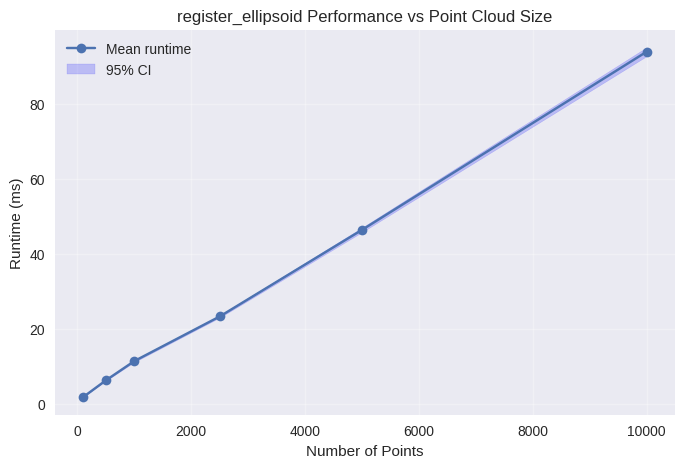

In [62]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

print("=== PERFORMANCE ANALYSIS ===")

# Test different point cloud sizes
sizes = [100, 500, int(1e+3), int(2.5e+3), int(5e+3), int(1e+4)]
means = []
cis   = []
repeats = 1000  # number of timing runs per size

for size in sizes:
    # Generate test data once per size
    phi = np.random.uniform(0, np.pi, size)
    theta = np.random.uniform(0, 2*np.pi, size)
    src = np.vstack([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ]).T * 3

    T_true = random_rigid_transform()
    dst = apply_transform(src, T_true)
    noise = np.random.normal(scale=0.02, size=dst.shape)
    dst_noisy = dst + noise

    # Build a Timer that calls our init
    timer = timeit.Timer(lambda: register_ellipsoid(src, dst_noisy))
    raw_times = np.array(timer.repeat(repeat=repeats, number=1))  # seconds per run
    times_ms = raw_times * 1000  # convert to ms

    mean_ms = times_ms.mean()
    std_ms  = times_ms.std(ddof=1)
    sem = std_ms / np.sqrt(repeats)
    ci95 = 1.96 * sem

    means.append(mean_ms)
    cis.append(ci95)

    print(f"Size {size:5d}: {mean_ms:7.3f} ms ± {ci95:5.3f} ms (95% CI)")

# Plot performance with 95%-confidence band
plt.figure(figsize=(8,5))
means = np.array(means)
cis   = np.array(cis)

plt.plot(sizes, means, 'o-', label='Mean runtime')
plt.fill_between(sizes, means - cis, means + cis,
                 color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Number of Points')
plt.ylabel('Runtime (ms)')
plt.title('register_ellipsoid Performance vs Point Cloud Size')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Test 6 - Error Analysis

=== NOISE ROBUSTNESS ANALYSIS ===
Noise std 0.01: 0.025449 ± 0.005931 (95% CI)
Noise std 0.02: 0.050276 ± 0.008348 (95% CI)
Noise std 0.05: 0.124186 ± 0.012803 (95% CI)
Noise std 0.10: 0.277189 ± 0.030946 (95% CI)
Noise std 0.20: 0.591391 ± 0.047353 (95% CI)
Noise std 0.30: 1.015088 ± 0.072009 (95% CI)
Noise std 0.40: 1.290527 ± 0.075787 (95% CI)
Noise std 0.50: 1.949198 ± 0.096421 (95% CI)


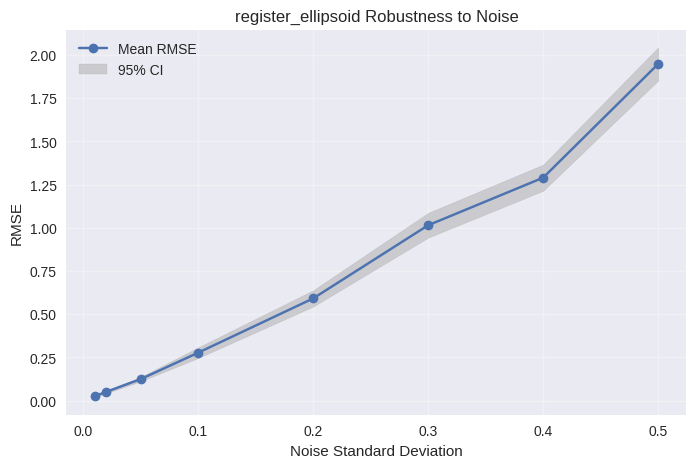

In [63]:
import numpy as np
import matplotlib.pyplot as plt

print("=== NOISE ROBUSTNESS ANALYSIS ===")

# Noise levels to test
noise_levels = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Number of independent runs per noise level
repeats = 1000

means = []
cis   = []

for noise_std in noise_levels:
    rmse_vals = []
    for _ in range(repeats):
        # Generate fresh sphere data
        phi = np.random.uniform(0, np.pi, 300)
        theta = np.random.uniform(0, 2*np.pi, 300)
        src = np.vstack([
            np.sin(phi) * np.cos(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(phi)
        ]).T * 3

        # Apply ground-truth rigid transform
        T_true = random_rigid_transform()
        dst_clean = apply_transform(src, T_true)

        # Add noise
        noise = np.random.normal(scale=noise_std, size=dst_clean.shape)
        dst_noisy = dst_clean + noise

        # Run ellipsoid init
        T_est = register_ellipsoid(src, dst_noisy)
        aligned = apply_transform(src, T_est)

        # Compute RMSE
        diff = aligned - dst_noisy
        rmse = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
        rmse_vals.append(rmse)

    rmse_arr = np.array(rmse_vals)
    mean_rmse = rmse_arr.mean()
    sem       = rmse_arr.std(ddof=1) / np.sqrt(repeats)
    ci95      = 1.96 * sem

    means.append(mean_rmse)
    cis.append(ci95)

    print(f"Noise std {noise_std:4.2f}: {mean_rmse:.6f} ± {ci95:.6f} (95% CI)")

# Plot mean RMSE with 95% confidence band
means = np.array(means)
cis   = np.array(cis)

plt.figure(figsize=(8,5))
plt.plot(noise_levels, means, 'o-', label='Mean RMSE')
plt.fill_between(noise_levels, means - cis, means + cis,
                 color='gray', alpha=0.3, label='95% CI')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('RMSE')
plt.title('register_ellipsoid Robustness to Noise')
plt.legend()
plt.grid(alpha=0.3)
plt.show()